# Rate-Based Model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from parameters import *

import numba
from numba import jit

import numpy as np
from scipy import special, integrate
import matplotlib.pyplot as plt

In [3]:
# Jahr-Stevens formula functions
@jit(nopython=True)
def J(V):
    result = np.empty_like(V)
    for i in range(V.shape[0]):
        result[i] = 1 + gamma_JahrStevens * np.exp(-beta_JahrStevens * V[i])
    return result
        
@jit(nopython=True)
def J_2(V):
    result = np.empty_like(V)
    J_V = J(V)
    for i in range(V.shape[0]):
        numerator = J_V[i] + beta_JahrStevens * (V[i] - V_E)*(J_V[i] - 1)
        denominator = J_V[i]**2
        result[i] = numerator / denominator
    return result

J_2(np.full(p, V_drive))

array([-0.23389231, -0.23389231, -0.23389231])

In [4]:
# Functions to compute steady-state NMDA channels
@jit(nopython=True)
def my_factorial(n):
    if n <= 1.:
        return 1.
    return my_factorial(n-1) * n

@jit(nopython=True)
def my_binomial(n, m):
    return my_factorial(n) / (my_factorial(m) * my_factorial(n-m))


@jit(nopython=True)
def _get_Tn_summand(n, m, nu):
    assert n >= 1 and m >= 0
    binom_coeff = (-1)**m * my_binomial(n, m)
    result = np.empty_like(nu)
    for i in range(nu.shape[0]):
        numerator = tau_NMDA_rise * (1 + nu[i] * tau_NMDA)
        denominator = tau_NMDA_rise * (1 + nu[i] * tau_NMDA) + m * tau_NMDA_decay
        result[i] = binom_coeff * numerator / denominator
    return result

def _get_Tn_summand_scipy(n, m, nu):
    assert n >= 1 and m >= 0
    binom_coeff = (-1)**m * special.binom(n, m)
    numerator = tau_NMDA_rise * (1 + nu * tau_NMDA)
    denominator = tau_NMDA_rise * (1 + nu * tau_NMDA) + m * tau_NMDA_decay
    return binom_coeff * numerator / denominator

@jit(nopython=True)
def _get_Tn(n, nu):
    assert n >= 1
    Tn = np.zeros_like(nu)
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand(n, m, nu)
    return Tn

def _get_Tn_scipy(n, nu):
    assert n >= 1
    Tn = 0
    for m in np.arange(0, n+1):
        Tn += _get_Tn_summand_scipy(n, m, nu)
    return Tn

@jit(nopython=True)
def psi(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = np.zeros_like(nu)
    for n in np.arange(1, n_truncate+1):
        Tn = _get_Tn(n, nu)
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / my_factorial(n+1)
        summation += summand_coeff * Tn
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

def psi_scipy(nu, n_truncate=5):
    """
    Computes fraction of open NMDA channels given presynaptic firing rate nu 
    up until truncation round-off n_truncate.
    """
    coeff = nu * tau_NMDA / (1 + nu * tau_NMDA)
    summation = 0
    for n in np.arange(1, n_truncate+1):
        summand_coeff = ((-alpha * tau_NMDA_rise)**n) / special.factorial(n+1)
        summation += summand_coeff * _get_Tn_scipy(n, nu)
    return coeff * (1 + summation / (1 + nu * tau_NMDA))

# psi(rate_ext) == psi_scipy(rate_ext)
test_rate = np.full(p, rate_ext)
np.allclose(psi(test_rate), psi_scipy(test_rate))

True

In [5]:
# not used
gamma = 0.8  # 0.641 in Wong&Wang
@jit(nopython=True)
def psi_approx(nu):
    """Following Wong&Wang 2006, we can approximate psi thusly"""
    product = gamma * nu * tau_NMDA
    return product/(1 + product)

@jit(nopython=True)
def psi_regular(nu):
    """Gives the steady-state value under regular firing"""
    product = nu * tau_NMDA
    return product/(1 + product)

# psi_approx(np.full(p, rate_ext)), psi_regular(np.full(p, rate_ext))

In [6]:
# Weights and mask
pyramidal_mask = np.array([True] * (p+1) + [False])

# (W * 100).astype(int).astype(float) / 100

In [7]:
@jit(nopython=True)
def _rate_upperbound_vectorised(
    V_SS, sigma, tau_m, tau_rp,
):
    summand = (V_thr - V_SS)/sigma
    summand *= 1 + 0.5 * tau_AMPA/tau_m
    summand += 1.03 * np.sqrt(tau_AMPA/tau_m) - 0.5 * tau_AMPA/tau_m
    return summand

@jit(nopython=True)
def _rate_lowerbound_vectorised(
    V_SS, sigma,
):
    return (V_reset - V_SS) / sigma

def _siegert_integrand(x):
    return np.exp(x**2)*(1+special.erf(x))


root_pi = np.sqrt(np.pi)
def rate_vectorised(
    V_SS, sigma, tau_m, tau_rp
):
    integration_results = np.empty(V_SS.shape)
    UB = _rate_upperbound_vectorised(
        V_SS, sigma,
        tau_m=tau_m, tau_rp=tau_rp
    )
    LB = _rate_lowerbound_vectorised(
        V_SS, sigma
    )
    # There would be a dynamic programming solution
    # to computing multiple integrals by splitting 
    # this up into subintervals, integrating over 
    # them and adding them back together
    for i, (lb, ub) in enumerate(zip(LB, UB)):
        integral, error = integrate.quad(
            _siegert_integrand, lb, ub
        )
        integration_results[i] = integral
    return (tau_rp + tau_m * root_pi * integration_results)**-1

# rate_vectorised(np.full(5, V_drive), np.full(5, 2e-3), tau_m_E, tau_rp_E)

In [8]:
# @jit(nopython=True)  # faster without jit for now
def ds_NMDA_dt(s_NMDA, nu):
    psi_nu = psi(nu)
    psi_nu[~pyramidal_mask] = 0.0
    tau_NMDA_eff = tau_NMDA * (1 - psi_nu)
    dsdt = -(s_NMDA - psi_nu) / tau_NMDA_eff
    return dsdt

# @jit(nopython=True)
def dic_noise_dt(
    ic_noise, sigma_noise=7e-12#*5/p
):
    eta = np.random.randn(*ic_noise.shape)
    dicdt = (-ic_noise + eta * np.sqrt(tau_AMPA/defaultdt) * sigma_noise) / tau_AMPA
    return dicdt

In [9]:
# Following W&W2006
# 1. Treat all firing rates and synaptic variables as dynamic
# 2. use tau_r=2ms for the firing rate dynamics
# 3. phi(I_syn) = rates(V_SS_new = V_L - I_syn / g_m)

# Can't jit rate (yet)
# @jit(nopython=True)
def phi(
    I_syn, g_m, sigma, tau_m, tau_rp
):
    V_SS = V_L - I_syn/g_m
    return rate_vectorised(V_SS, sigma, tau_m, tau_rp)

tau_r = 2e-3
# @jit(nopython=True)
def dnu_dt(
    nu, I_syn, g_m, sigma, tau_m, tau_rp
):
    phi_Isyn = phi(
        I_syn, g_m, sigma, tau_m, tau_rp
    )
    deriv = (-nu + phi_Isyn)/tau_r
    return deriv

@jit(nopython=True)
def ds_AMPA_dt(s_AMPA, nu):
    deriv = -s_AMPA/tau_AMPA + nu
    deriv[~pyramidal_mask] = 0.0
    return deriv

@jit(nopython=True)
def ds_GABA_dt(s_GABA, nu):
    deriv = -s_GABA/tau_GABA + nu
    deriv[pyramidal_mask] = 0.0
    return deriv

BCM-rule from 1994 (Law and Cooper):

$$
\begin{split}
% y &= \sigma \left( \sum_j w_j x_j \right)\\
\frac{dw_{ij}}{dt} &= \nu_i(\nu_i - \theta_{M,i}) \nu_j / \theta_{M,i}\\
\theta_M &= \mathbb{E}[\nu^2]
\end{split}
$$

In [10]:
plasticity_mask_source = pyramidal_mask.copy()
plasticity_mask_target = np.full_like(plasticity_mask_source, True)
# plasticity_mask = np.outer(plasticity_mask_target, plasticity_mask_source)

tau_theta = 0.1
@jit(nopython=True)
def dtheta_BCM_dt(theta, nu):
    """
    tau_theta * dtheta/dt = -theta + nu**2
    
    Units of theta are technically different to those of nu. 
    There should be a constant to fix this.
    """
    dtheta_dt = (-theta + nu**2)/tau_theta
    return dtheta_dt

In [11]:
tau_W = 10.
@jit(nopython=True)
def dW_dt_BCM(W, nu, theta):
    dW_dt = (np.outer(nu * (nu-theta), nu) / theta.reshape(-1, 1)) / tau_W
    # BCM has a positive feedback loop on recurrent weights
    for i in range(dW_dt.shape[0]):
        dW_dt[i,i] = 0.0
    for j, b in enumerate(plasticity_mask_source):
        if not b:
            dW_dt[:, j] = 0.0
    for i, b in enumerate(plasticity_mask_target):
        if not b:
            dW_dt[i, :] = 0.0
#     dW_dt[~plasticity_mask] = 0.0
    return dW_dt

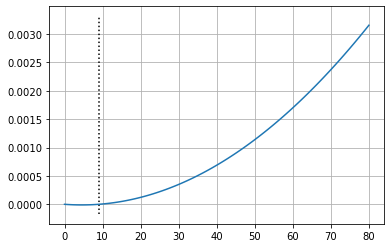

In [12]:
theta = 3**2
y_hz = np.linspace(0, 80, 100)
x_hz = 1
plt.plot(y_hz, defaultdt * np.outer(y_hz * (y_hz-theta), x_hz) / (theta * tau_W))
min_, max_ = plt.ylim()
plt.vlines(theta, min_, max_, ls=':', color='k')
plt.grid()

In [13]:
from tqdm import tqdm

def simulate(
    initialisation_steps=10,
    lambda_=0.8,
    total_time=runtime,
    coherence=0.5,
    plasticity=True,
    W=None
):
    ## Initialise arrays for computation
    # For some reason this can't be numba.jit-ed
    C_k = np.array([N_non] + [N_sub] * p + [N_I])
    g_m = np.array([g_m_E] * (p+1) + [g_m_I])
    C_m = np.array([C_m_E] * (p+1) + [C_m_I])
    tau_m = np.array([tau_m_E] * (p+1) + [tau_m_I])
    tau_rp = np.array([tau_rp_E] * (p+1) + [tau_rp_I])
    nu = np.array([rate_pyramidal] * (p+1) + [rate_interneuron])
    
    # set weights
    if W is None:
        W = np.ones((p+2, p+2))  # from column to row
        for i in range(0, p+1):
            weights = np.full(p+2, w_minus)
            if i > 0:
                weights[i] = w_plus
            else:
                weights[i] = 1.0
            weights[-1] = 1.0
            weights[0] = 1.0
            W[:,i] = weights
    else:
        W = W.copy()

    # AMPA
    g_AMPA = np.array([g_AMPA_rec_E]* (p+1) + [g_AMPA_rec_I])
    s_AMPA = tau_AMPA * nu
    s_AMPA[~pyramidal_mask] = 0.  # inhibitory neurons won't feed AMPA-mediated synapses
    ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
    ic_AMPA = g_AMPA * (W @ ip_AMPA)

    # AMPA_ext
    g_AMPA_ext = np.array([g_AMPA_ext_E]* (p+1) + [g_AMPA_ext_I])
    s_AMPA_ext = np.full_like(
        s_AMPA,
        tau_AMPA * rate_ext
    )  # array to allow for differing inputs
    ip_AMPA_ext = (V_drive - V_E) * C_ext * s_AMPA_ext
    ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext

    # GABA
    g_GABA = np.array([g_GABA_E]* (p+1) + [g_GABA_I])
    s_GABA = tau_GABA * nu
    s_GABA[pyramidal_mask] = 0.
    ip_GABA = (V_drive - V_I) * C_k * s_GABA
    ic_GABA = g_GABA * (W @  ip_GABA)

    # NMDA - requires self-consistent calculation
    g_NMDA = np.array([g_NMDA_E]* (p+1) + [g_NMDA_I])
    # can I speed these up with @numba.jit?
    g_NMDA_eff = lambda V: g_NMDA * J_2(V)
    V_E_eff = lambda V: V - (1 / J_2(V)) * (V - V_E) / J(V)

    s_NMDA = psi(nu)
    s_NMDA[~pyramidal_mask] = 0.
    V_avg_initial = -56e-3  # initial guess for determining V_avg
    
    # Initialise V_avg, V_SS
    # can I speed this up with @numba.jit?
    V_avg = np.full(p+2, V_avg_initial)
    for k in range(initialisation_steps):
        g_NMDA_eff_V = g_NMDA_eff(V_avg)
        V_E_eff_V = V_E_eff(V_avg)
        ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
        ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)
        I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA
        V_SS = V_L - I_syn / g_m  # notice the minus, because current flows out?
        V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp
    
    # set sigma
    sigma = np.sqrt(
        g_AMPA_ext**2 * (V_drive - V_E)**2 * C_ext * rate_ext * tau_AMPA**2 / (g_m**2 * tau_m)
    )
    sigma[:-1] = lambda_ * (2e-3) + (1-lambda_) * sigma[:-1]

    # initialise values for learning
    theta_BCM = nu ** 2

    ## Initialise arrays to track values, and for simulation
    times = np.arange(0, total_time, defaultdt)
#     nu_tracked = np.zeros((p+2, times.shape[0]))
#     s_NMDA_tracked = np.zeros((p+2, times.shape[0]))
#     s_AMPA_tracked = np.zeros((p+2, times.shape[0]))
#     s_GABA_tracked = np.zeros((p+2, times.shape[0]))
#     I_syn_tracked = np.zeros((p+2, times.shape[0]))
    
#     theta_BCM_tracked = np.zeros((p+2, times.shape[0]))
#     W_tracked = np.zeros((p+2, p+2, times.shape[0]))
    nu_tracked = np.full((p+2, times.shape[0]), np.nan)
    s_NMDA_tracked = np.full((p+2, times.shape[0]), np.nan)
    s_AMPA_tracked = np.full((p+2, times.shape[0]), np.nan)
    s_GABA_tracked = np.full((p+2, times.shape[0]), np.nan)
    I_syn_tracked = np.full((p+2, times.shape[0]), np.nan)
    
    theta_BCM_tracked = np.full((p+2, times.shape[0]), np.nan)
    W_tracked = np.full((p+2, p+2, times.shape[0]), np.nan)
    
    if not plasticity:
        W_tracked = np.full((p+2, p+2, times.shape[0]), W.reshape(p+2, p+2, 1))
    
    ic_noise = np.zeros_like(s_AMPA)
    for itr, t in tqdm(enumerate(times)):
        ip_AMPA = (V_drive - V_E) * C_k * s_AMPA
        ic_AMPA = g_AMPA * (W @ ip_AMPA)

        g_NMDA_eff_V = g_NMDA_eff(V_avg)
        V_E_eff_V = V_E_eff(V_avg)
        ip_NMDA = (V_drive - V_E_eff_V) * C_k * s_NMDA
        ic_NMDA = g_NMDA_eff_V * (W @ ip_NMDA)

        ip_GABA = (V_drive - V_I) * C_k * s_GABA
        ic_GABA = g_GABA * (W @  ip_GABA)


        ## LATEST CHANGE: added noise adapting to changing input by adapting s_AMPA_ext
        s_AMPA_ext = np.full_like(
            s_AMPA,
            tau_AMPA * rate_ext
        )
        if t > 200e-3 and t < 225e-3:  #225e-3:  #
            # mu_0 ~= 0.05 in Wong&Wang2006, taken by comparison with mean external input
#             multiplier = np.ones(p+2)
#             multiplier[1] += 0.05 * (1+coherence)
#             multiplier[2] += 0.05 * (1-coherence)
#             s_AMPA_ext = s_AMPA_ext * multiplier

            # increase input by roughly 1.5 times
            s_AMPA_ext[1] = s_AMPA_ext[1] * 1.5  #(25. * b2.Hz + rate_ext) / rate_ext
        
        ip_AMPA_ext = (V_drive - V_E) * C_ext * s_AMPA_ext
        ic_AMPA_ext = g_AMPA_ext * ip_AMPA_ext
        sigma = np.sqrt(
            g_AMPA_ext**2 * (V_drive - V_E)**2 * C_ext * s_AMPA_ext * tau_AMPA / (g_m**2 * tau_m)
        )
        sigma[:-1] = lambda_ * (2e-3) + (1-lambda_) * sigma[:-1]
        ## END OF LAST CHANGE

        I_syn = ic_AMPA + ic_AMPA_ext + ic_NMDA + ic_GABA + ic_noise

        dnu_dt_now = dnu_dt(
            nu, I_syn,
            sigma=sigma,
            g_m=g_m,
            tau_m=tau_m,
            tau_rp=tau_rp
        )
        dic_noise_dt_now = dic_noise_dt(ic_noise)
        ds_NMDA_dt_now = ds_NMDA_dt(s_NMDA, nu)
        ds_AMPA_dt_now = ds_AMPA_dt(s_AMPA, nu)
        ds_GABA_dt_now = ds_GABA_dt(s_GABA, nu)
        
        if plasticity:
            dtheta_BCM_dt_now = dtheta_BCM_dt(theta_BCM, nu)
            dW_dt_now = dW_dt_BCM(W, nu, theta_BCM)
        

        nu += dnu_dt_now * defaultdt
        ic_noise += dic_noise_dt_now * defaultdt
        s_NMDA += ds_NMDA_dt_now * defaultdt
        s_AMPA += ds_AMPA_dt_now * defaultdt
        s_GABA += ds_GABA_dt_now * defaultdt
        
        if plasticity:
            theta_BCM += dtheta_BCM_dt_now * defaultdt
            W += dW_dt_now * defaultdt
            W = W.clip(0.0, np.inf)

        nu_tracked[:, itr] = nu
        s_NMDA_tracked[:, itr] = s_NMDA
        s_AMPA_tracked[:, itr] = s_AMPA
        s_GABA_tracked[:, itr] = s_GABA
        I_syn_tracked[:, itr] = I_syn
        
        if plasticity:
            theta_BCM_tracked[:, itr] = theta_BCM
            W_tracked[:, :, itr] = W

        # Not mentioned in W&W2006:
        V_SS = V_L - I_syn / g_m
        V_avg = V_SS - (V_thr-V_reset)*nu*tau_m - (V_SS-V_reset)*nu*tau_rp
        
        if np.any(np.isnan(nu)):
            break

    return  times,\
            nu_tracked,\
            s_NMDA_tracked,\
            s_AMPA_tracked,\
            s_GABA_tracked,\
            I_syn_tracked,\
            theta_BCM_tracked,\
            W_tracked

In [14]:
# %load_ext snakeviz

In [15]:
# %snakeviz simulate()

In [16]:
# simulate(total_time=20e-3)
times,\
nu_tracked,\
s_NMDA_tracked,\
s_AMPA_tracked,\
s_GABA_tracked,\
I_syn_tracked,\
theta_BCM_tracked,\
W_tracked = simulate(total_time=0.6, coherence=0.7, plasticity=False)

3923it [00:02, 1855.43it/s]WARNING    <ipython-input-7-6bb2f7acddb1>:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, error = integrate.quad(
 [py.warnings]
4114it [00:02, 1844.48it/s]WARNING    <ipython-input-7-6bb2f7acddb1>:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral, error = integrate.quad(
 [py.warnings]
12000it [00:44, 267.49it/s]


In [17]:
# plt.figure()

# first_nan = np.any(np.isnan(W_tracked), axis=(0, 1)).argmax()
# plt.imshow(W_tracked[:,:,first_nan-1])
# plt.colorbar()
# for i in range(p+2):
#     for j in range(p+2):
#         plt.text(j, i, f"{W_tracked[i,j,first_nan-1]:.2f}",
#                        ha="center", va="center", color="w")

# plt.figure()
# # plt.plot(times, np.max(W_tracked, axis=(0, 1)), label='max')
# # plt.plot(times, np.min(W_tracked, axis=(0, 1)), label='min')
# weight_lines = plt.plot(times, W_tracked[0, :, :].T)
# plt.legend(
#     weight_lines,
#     [f'{k}->non-sel' for k in ['non-sel']+list(range(1,p+1))+['inh'] ],
# #     title='neuron population',
# )

# plt.figure()
# weight_lines = plt.plot(times, W_tracked[4, :, :].T)
# plt.legend(
#     weight_lines,
#     [f'{k}->4' for k in ['non-sel']+list(range(1,p+1))+['inh'] ],
# #     title='neuron population',
# )
# plt.show()

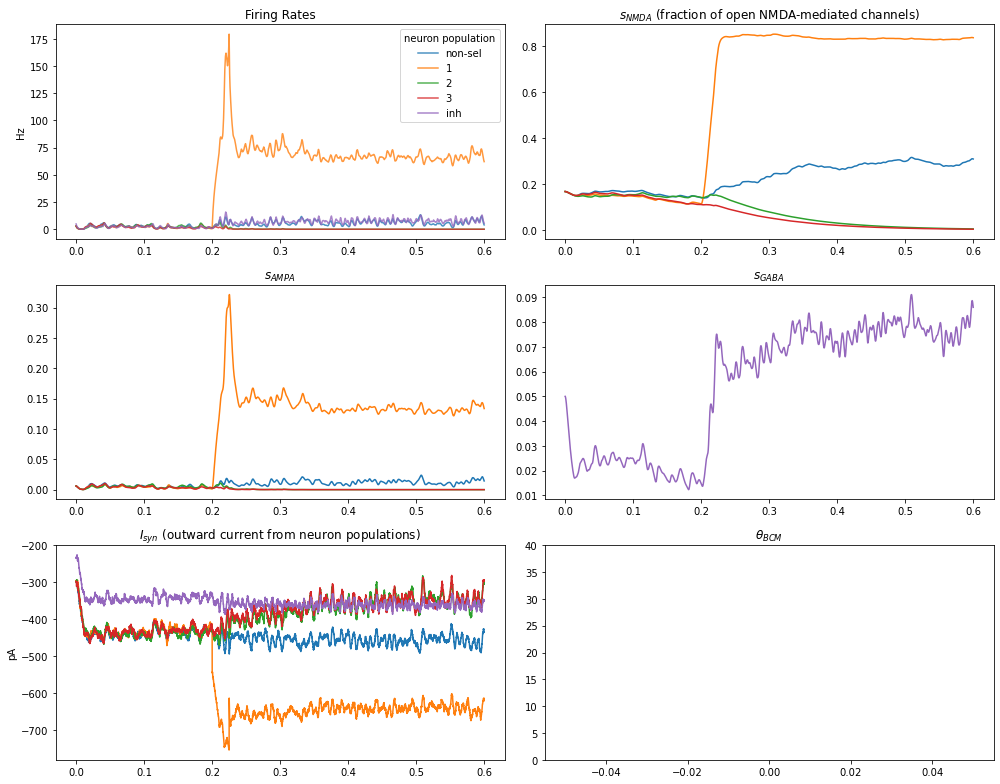

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(14,11))

# clear_output(wait=True)
rates_lines = axes[0][0].plot(
    times, nu_tracked.T,
    alpha=0.8
)
axes[0][0].legend(
    rates_lines,
    ['non-sel'] + list(range(1, p+1)) +  ['inh'],
    title='neuron population',
)
# _, ymax = axes[0][0].get_ylim()
# axes[0][0].set_ylim([0., min(40., ymax)])

axes[0][0].set_ylabel('Hz')
axes[0][0].set_title('Firing Rates')
axes[0][1].plot(times, s_NMDA_tracked[pyramidal_mask, :].T)
axes[0][1].set_title('$s_{NMDA}$ (fraction of open NMDA-mediated channels)')
axes[1][0].plot(times, s_AMPA_tracked[pyramidal_mask, :].T)
axes[1][0].set_title('$s_{AMPA}$')
axes[1][1].plot(times, s_GABA_tracked[~pyramidal_mask, :].T, color=rates_lines[-1].get_color())
axes[1][1].set_title('$s_{GABA}$')
axes[2][0].plot(times, I_syn_tracked.T * 1e12)
axes[2][0].set_ylabel('pA')
axes[2][0].set_title('$I_{syn}$ (outward current from neuron populations)')
axes[2][1].plot(times, theta_BCM_tracked.T)
axes[2][1].set_title(r'$\theta_{BCM}$')
axes[2][1].set_ylim([0., 40.])

plt.tight_layout()
plt.show(fig)

# add to discussion reasons (or lack thereof) for choosing times
# for RL tasks

# compare stable states in terms of s_NMDA levels

# Spiking Model

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from parameters import *
import brian2 as b2
from brian2 import np, plt

In [21]:
b2.start_scope()

P_E = b2.NeuronGroup(
    N_E, eqs_current_E, threshold='v > V_thr',
    reset='v = V_reset', refractory='tau_rp_E', method='euler'
)
P_E.v = namespace['V_L']
P_E.s_AMPA_ext = 4.8
P_I = b2.NeuronGroup(
    N_I, eqs_current_I, threshold='v > V_thr',
    reset='v = V_reset', refractory='tau_rp_I', method='euler'
)
P_I.v = namespace['V_L']
P_I.s_AMPA_ext = 4.8

C_E_E = b2.Synapses(P_E, P_E, 
    model=eqs_glut, on_pre=eqs_pre_glut, on_post=eqs_post_glut,
    method='euler', name='C_E_E')
C_E_E.connect('i != j')
C_E_E.w[:] = 1.0
for pi in range(N_non, N_non + p * N_sub, N_sub):
    # internal other subpopulation to current nonselective
    C_E_E.w[C_E_E.indices[:, pi:pi + N_sub]] = w_minus
    # internal current subpopulation to current subpopulation
    C_E_E.w[C_E_E.indices[pi:pi + N_sub, pi:pi + N_sub]] = w_plus

C_E_I = b2.Synapses(
    P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler',
    name='C_E_I'
)
C_E_I.connect()
C_E_I.w[:] = 1.0
C_I_I = b2.Synapses(
    P_I, P_I, on_pre=eqs_pre_gaba, method='euler',
    name='C_I_I'
)
C_I_I.connect('i != j')
# C_I_I.w[:] = 1.0
C_I_E = b2.Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
C_I_E.connect()
# C_I_E.w[:] = 1.0

C_P_E = b2.PoissonInput(
    P_E, 's_AMPA_ext', C_ext, rate_ext*b2.Hz, '1',
#         name='C_P_E'
)
C_P_I = b2.PoissonInput(
    P_I, 's_AMPA_ext', C_ext, rate_ext*b2.Hz, '1',
#         name='C_P_I'
)



C_selection = int(f * C_ext)
stimtime = 1
rate_selection = 25 * b2.Hz  # * (5/p)
#     stimuli1 = b2.TimedArray(np.r_[np.zeros(40), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
stimuli1 = b2.TimedArray(np.r_[np.zeros(8), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
input1 = b2.PoissonInput(
    P_E[N_non:N_non + N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli1(t)'
)
# stimuli2 = b2.TimedArray(np.r_[np.zeros(80), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
# input2 = b2.PoissonInput(
#     P_E[N_non + N_sub:N_non + 2 * N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli2(t)'
# )
# stimuli_reset = b2.TimedArray(np.r_[np.zeros(120), np.ones(2), np.zeros(100)], dt=25 * b2.ms)
# input_reset_I = b2.PoissonInput(P_E, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')
# input_reset_E = b2.PoissonInput(P_I, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')

namespace['stimuli1'] = stimuli1
# namespace['stimuli2'] = stimuli2
# namespace['stimuli_reset'] = stimuli_reset

N_activity_plot = 15
sp_E_sels = [
    b2.SpikeMonitor(P_E[pi:pi + N_activity_plot], name=f'sp_E_{int((pi-N_non)/N_sub) + 1}')
    for pi in range(N_non, N_non + p * N_sub, N_sub)
]
sp_E = b2.SpikeMonitor(P_E[:N_activity_plot], name=f'sp_E_non')
sp_I = b2.SpikeMonitor(P_I[:N_activity_plot], name=f'sp_I')

r_E_sels = [
    b2.PopulationRateMonitor(P_E[pi:pi + N_sub], name=f'r_E_{int((pi-N_non)/N_sub) + 1}')
    for pi in range(N_non, N_non + p * N_sub, N_sub)]
r_E = b2.PopulationRateMonitor(P_E[:N_non], name=f'r_E_non')
r_I = b2.PopulationRateMonitor(P_I, name=f'r_I')

st_E_sels = [
    b2.StateMonitor(P_E[pi:pi + N_activity_plot], variables=True, record=True,
                   name=f'st_E_{int((pi-N_non)/N_sub) + 1}')
    for pi in range(N_non, N_non + p * N_sub, N_sub)]
st_E = b2.StateMonitor(P_E[:N_activity_plot], variables=True, record=True, name=f'st_E_non')
st_I = b2.StateMonitor(P_I[:N_activity_plot], variables=True, record=True, name=f'st_I')


net = b2.Network(b2.collect())
net.add(sp_E_sels)
net.add(r_E_sels)
net.add(st_E_sels)

net.store('initialised')

In [22]:
net.restore('initialised')

net.run(
    0.6*b2.second,
    report='stdout',
    namespace=namespace
)

Starting simulation at t=0. s for a duration of 0.6 s
295.1 ms (49%) simulated in 10s, estimated 10s remaining.
0.588 s (98%) simulated in 20s, estimated < 1s remaining.
0.6 s (100%) simulated in 20s


### The following plots can be used to compare the mean-field and true models

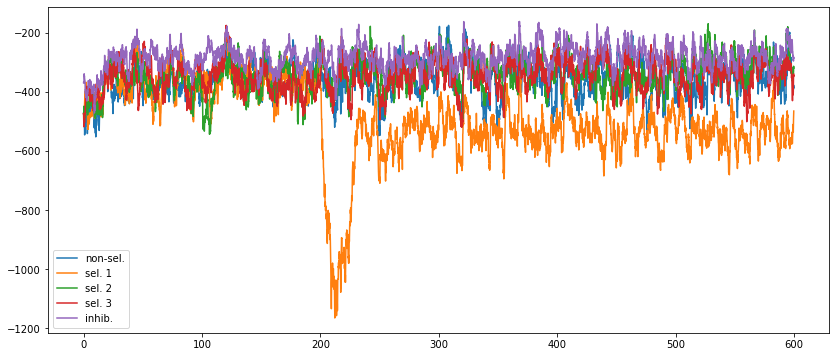

In [36]:
plt.figure(figsize=(14,6))

st = net['st_E_non']
mean_input = np.mean(st.I_syn / b2.pA, axis=0)
std_input = np.std(st.I_syn / b2.pA, axis=0)
b2.plot(st.t / b2.ms, mean_input, label='non-sel.')
# b2.fill_between(st.t / b2.ms, mean_input-std_input, mean_input+std_input, alpha=0.5)

for group in range(1,p+1):
    st = net[f'st_E_{group}']
    mean_input = np.mean(st.I_syn / b2.pA, axis=0)
    std_input = np.std(st.I_syn / b2.pA, axis=0)
    b2.plot(st.t / b2.ms, mean_input, label=f'sel. {group}')
#     b2.fill_between(st.t / b2.ms, mean_input-std_input, mean_input+std_input, alpha=0.5)

st = net[f'st_I']
mean_input = np.mean(st.I_syn / b2.pA, axis=0)
std_input = np.std(st.I_syn / b2.pA, axis=0)
b2.plot(st.t / b2.ms, mean_input, label=f'inhib.')
# b2.fill_between(st.t / b2.ms, mean_input-std_input, mean_input+std_input, alpha=0.5)

plt.legend()

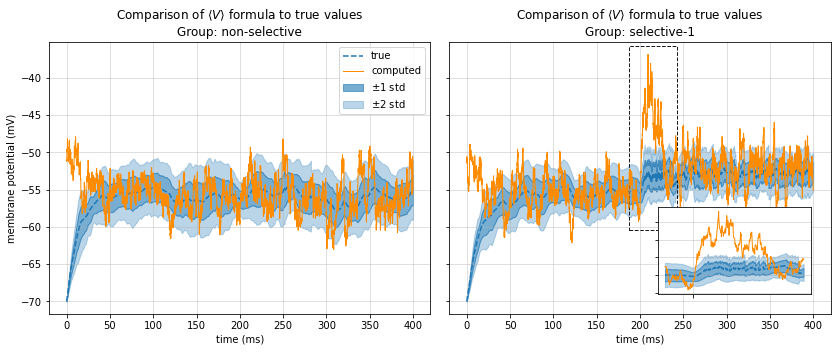

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle


def plot_average_membrane_potential(
    axes, population='E_non', group='non-selective',
    tmin=None, tmax=None, legend=True, title=True
):
    # using formula:
    V_SS = V_L * b2.volt - net['st_'+population].I_syn.mean(axis=0) / (g_m_E * b2.siemens)
    nu = net['r_'+population].smooth_rate('gaussian', 5*b2.ms)
    V_avg = V_SS - (V_thr - V_reset)*b2.volt * nu * tau_m_E * b2.second
    # using data:
    v_mean = b2.mean(net['st_'+population].v, axis=0)
    v_std = b2.std(net['st_'+population].v, axis=0)
    
    if tmin is None:
        tmin = net['r_'+population].t[0]
    if tmax is None:
        tmax = net['r_'+population].t[-1]
    mask = (net['r_I'].t >= tmin) & (net['r_I'].t <= tmax)
    
    true_line = axes.plot(
        net['r_'+population].t[mask] / b2.ms,
        v_mean[mask] / b2.mV,
        label='true',
        ls='--'
    )
    colour = true_line[0].get_color()
    axes.fill_between(
        net['r_'+population].t[mask] / b2.ms,
        (v_mean-v_std)[mask]/b2.mV,
        (v_mean+v_std)[mask]/b2.mV,
        alpha=0.6,
        label=r'$\pm 1$ std',
        color=colour
    )
    axes.fill_between(
        net['r_'+population].t[mask] / b2.ms,
        (v_mean-2*v_std)[mask]/b2.mV,
        (v_mean-v_std)[mask]/b2.mV,
        alpha=0.3,
        label=r'$\pm 2$ std',
        color=colour
    )
    axes.fill_between(
        net['r_'+population].t[mask] / b2.ms,
        (v_mean+2*v_std)[mask]/b2.mV,
        (v_mean+v_std)[mask]/b2.mV,
        alpha=0.3,
        color=colour
    )

    axes.plot(
        net['r_'+population].t[mask] / b2.ms,
        V_avg[mask] / b2.mV,
        label='computed',
        color='darkorange',
        lw=1
    )
    if legend:
        axes.legend()
    axes.grid(alpha=0.5)
    if title:
        axes.set_title(
            r'Comparison of $\langle V \rangle$ formula to true values'
            + f'\nGroup: {group}'
        )
    return None

        
fig, axes = plt.subplots(1,2,figsize=(14, 5), sharey=True)

axes[0].set_xlabel('time (ms)')
axes[1].set_xlabel('time (ms)')
axes[0].set_ylabel('membrane potential (mV)')

plot_average_membrane_potential(
    axes[0],
    tmax=400*b2.ms
)
plot_average_membrane_potential(
    axes[1], population='E_1', group='selective-1',
    tmax=400*b2.ms,
    legend=False
)

inset_ax = inset_axes(
    axes[1],
    width="40%", # width = 30% of parent_bbox
    height=1.2, # height : 1 inch
    loc=4,
    borderpad=2.0,
    axes_kwargs={'alpha':0.5}
)
plot_average_membrane_potential(
    inset_ax, population='E_1', group='selective-1',
    legend=False, title=False,
    tmin=190*b2.ms, tmax=240*b2.ms
)
inset_ax.set_xticklabels([])
inset_ax.set_yticklabels([])

left, right = inset_ax.get_xlim()
bottom, top = inset_ax.get_ylim()

ax_ticksy = axes[1].get_yticks()
ax_ticksy = ax_ticksy[ax_ticksy <= top]
ax_ticksy = ax_ticksy[ax_ticksy >= bottom]
inset_ax.set_yticks(ax_ticksy)

ax_ticksx = axes[1].get_xticks()
ax_ticksx = ax_ticksx[ax_ticksx <= right]
ax_ticksx = ax_ticksx[ax_ticksx >= left]
inset_ax.set_xticks(ax_ticksx)

rectangle_patch = Rectangle(
    (left, bottom), right-left, top-bottom,
    fill=False, clip_on=False, alpha=0.9, ls='--'
    )

axes[1].add_patch(rectangle_patch)

fig.subplots_adjust(wspace=0.05)

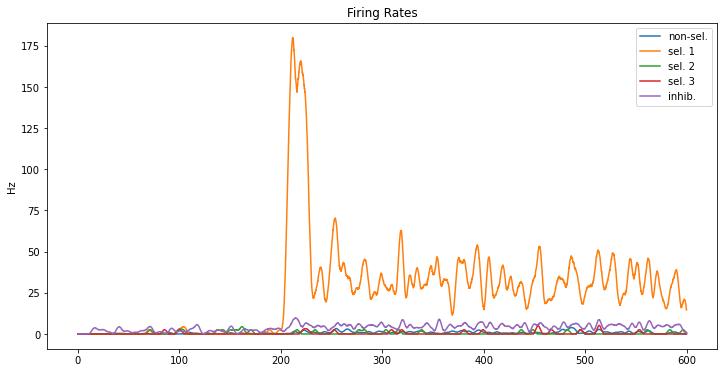

In [28]:
b2.figure(figsize=(12, 6))

window = 2*b2.ms

nu_E = net['r_E_non']
b2.plot(
    nu_E.t / b2.ms,
    nu_E.smooth_rate('gaussian', window),
#     color='r',
    label='non-sel.')

for group in range(1,p+1):
    nu_E_sel = net[f'r_E_{group}']
    b2.plot(
        nu_E_sel.t / b2.ms,
        nu_E_sel.smooth_rate('gaussian', window),
#         color='g',
        label=f'sel. {group}')

nu_I = net['r_I']
b2.plot(
    nu_I.t / b2.ms,
    nu_I.smooth_rate('gaussian', window),
#     color='b',
    label='inhib.')
b2.legend()
b2.ylabel('Hz')
b2.title('Firing Rates')
b2.show()

In [ ]:
# b2.title('Population rates')
# b2.xlabel('ms')
# b2.ylabel('Hz')

# b2.plot(
#     r_E.t / b2.ms, r_E.smooth_rate(width=5 * b2.ms) / b2.Hz,
#     label='nonselective')
# b2.plot(
#     r_I.t / b2.ms, r_I.smooth_rate(width=5 * b2.ms) / b2.Hz,
#     label='inhibitory')

# for i, r_E_sel in enumerate(r_E_sels[::-1]):
#     b2.plot(
#         r_E_sel.t / b2.ms, r_E_sel.smooth_rate(width=5 * b2.ms) / b2.Hz,
#         label='selective {}'.format(p - i))

# b2.legend()
# b2.figure()
# b2.title('Population activities ({} neurons/pop)'.format(N_activity_plot))
# b2.xlabel('ms')
# b2.yticks([])

# b2.plot(
#     sp_E.t / b2.ms, sp_E.i + (p + 1) * N_activity_plot, '.',
#     markersize=2, label='nonselective')
# b2.plot(
#     sp_I.t / b2.ms, sp_I.i + p * N_activity_plot, '.',
#     markersize=2, label='inhibitory')

# for i, sp_E_sel in enumerate(sp_E_sels[::-1]):
#     b2.plot(
#         sp_E_sel.t / b2.ms, sp_E_sel.i + (p - i - 1) * N_activity_plot, '.',
#         markersize=2, label='selective {}'.format(p - i))

# b2.legend()
# b2.show()